In [1]:
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6) #limits output of dataframes to 6 rows
set.seed(2024)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.5     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ recipes      1.0.8     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

In [2]:
loan_data <- read_csv("data/loan_data.csv")
loan_data <- loan_data |> 
    mutate(Loan_Status = as_factor(Loan_Status)) |>
    mutate(TotalLoanAmount = LoanAmount * Loan_Amount_Term) |>
    mutate(TotalIncome = ApplicantIncome + CoapplicantIncome)
loan_data

Rows: 381 Columns: 13
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (8): Loan_ID, Gender, Married, Dependents, Education, Self_Employed, Pro...
dbl (5): ApplicantIncome, CoapplicantIncome, LoanAmount, Loan_Amount_Term, C...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,TotalLoanAmount,TotalIncome
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<fct>,<dbl>,<dbl>
LP001003,Male,Yes,1,Graduate,No,4583,1508,128,360,1,Rural,N,46080,6091
LP001005,Male,Yes,0,Graduate,Yes,3000,0,66,360,1,Urban,Y,23760,3000
LP001006,Male,Yes,0,Not Graduate,No,2583,2358,120,360,1,Urban,Y,43200,4941
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
LP002978,Female,No,0,Graduate,No,2900,0,71,360,1,Rural,Y,25560,2900
LP002979,Male,Yes,3+,Graduate,No,4106,0,40,180,1,Rural,Y,7200,4106
LP002990,Female,No,0,Graduate,Yes,4583,0,133,360,0,Semiurban,N,47880,4583


In [3]:
loan_data <- loan_data |> drop_na()
loan_split <- initial_split(loan_data, prop = 0.75, strata = Loan_Status)
loan_train <- training(loan_split)
loan_test <- testing(loan_split)

## Data summary

In [4]:
loan_train_summary <- loan_train |>
    group_by(Loan_Status) |>
    summarize(Count = n(), MeanApplicantIncome = mean(ApplicantIncome), MeanLoanAmount = mean(LoanAmount), MeanLoanTerm = mean(Loan_Amount_Term))
loan_train_summary

Loan_Status,Count,MeanApplicantIncome,MeanLoanAmount,MeanLoanTerm
<fct>,<int>,<dbl>,<dbl>,<dbl>
N,66,3417.439,100.1667,345.0909
Y,164,3638.348,104.1646,340.7561


## Distributions of key predictors

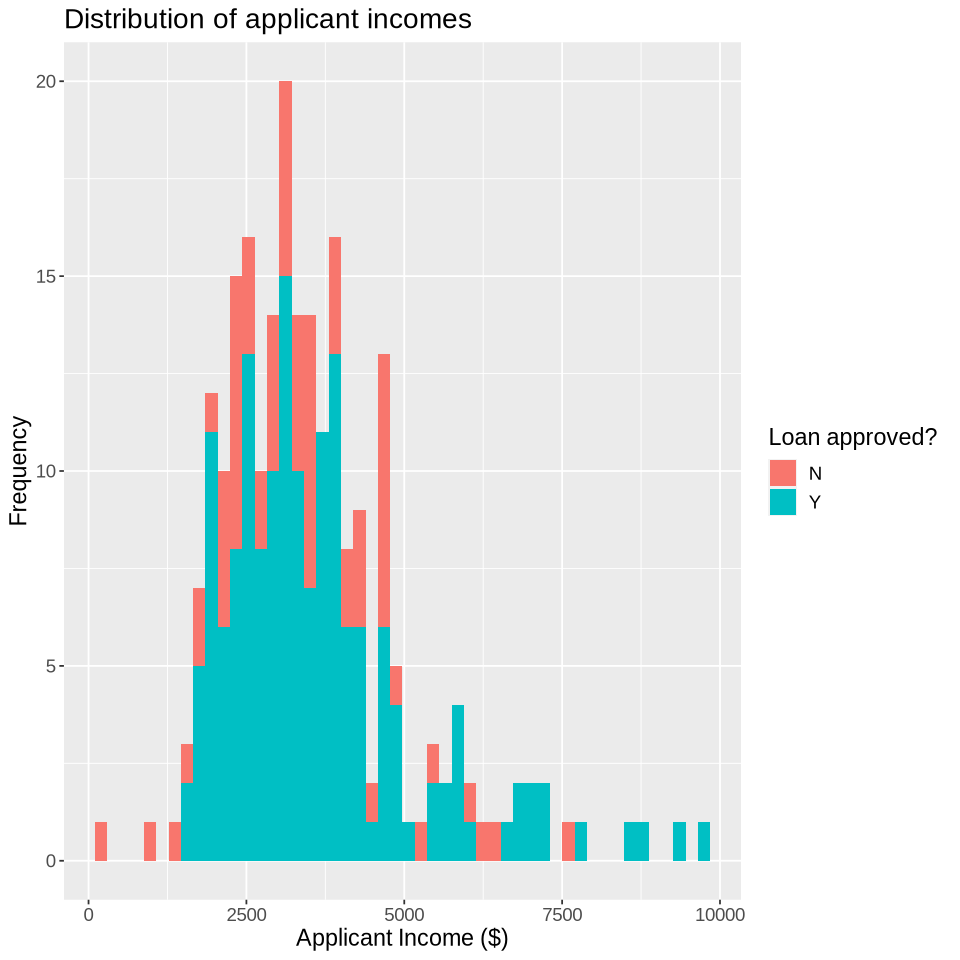

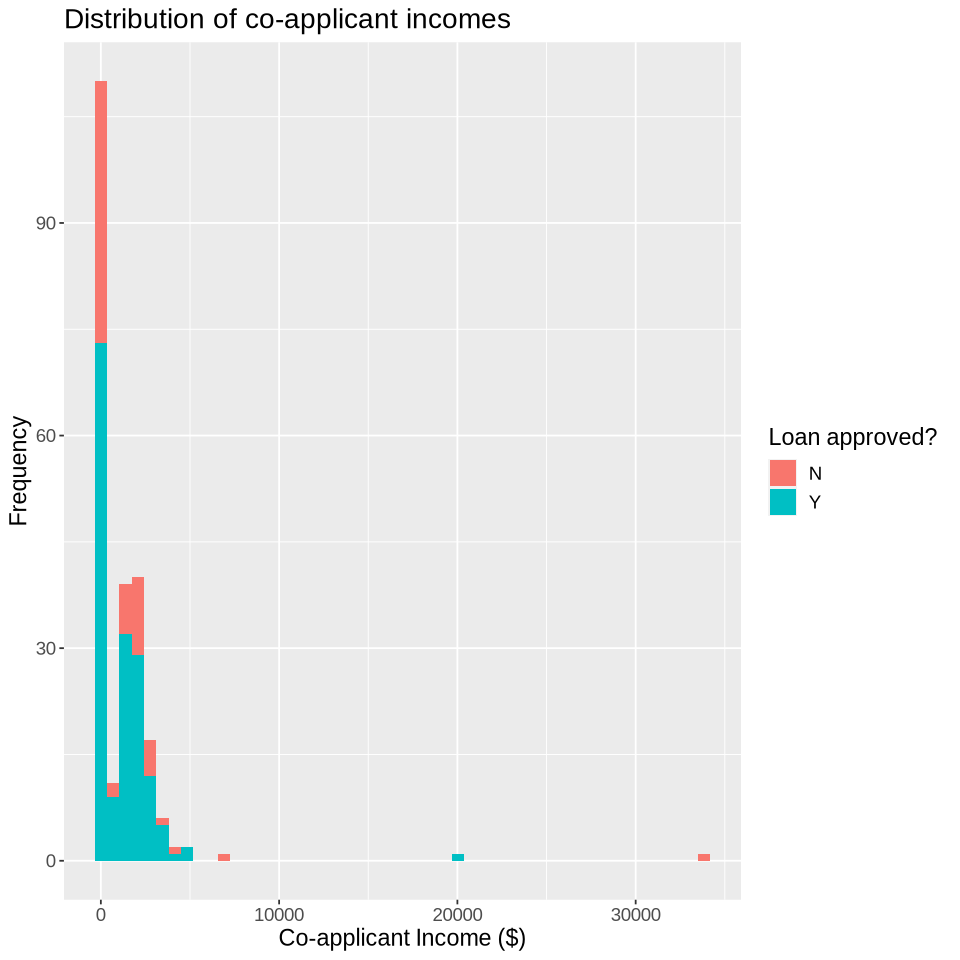

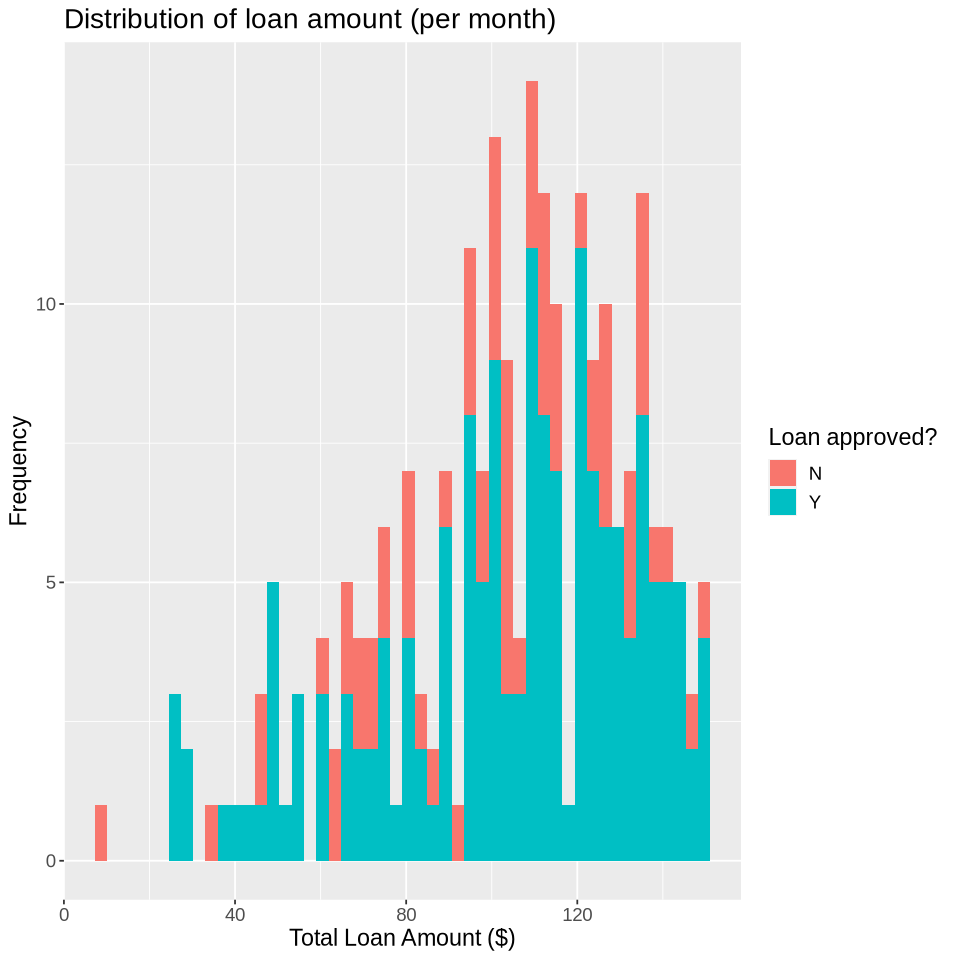

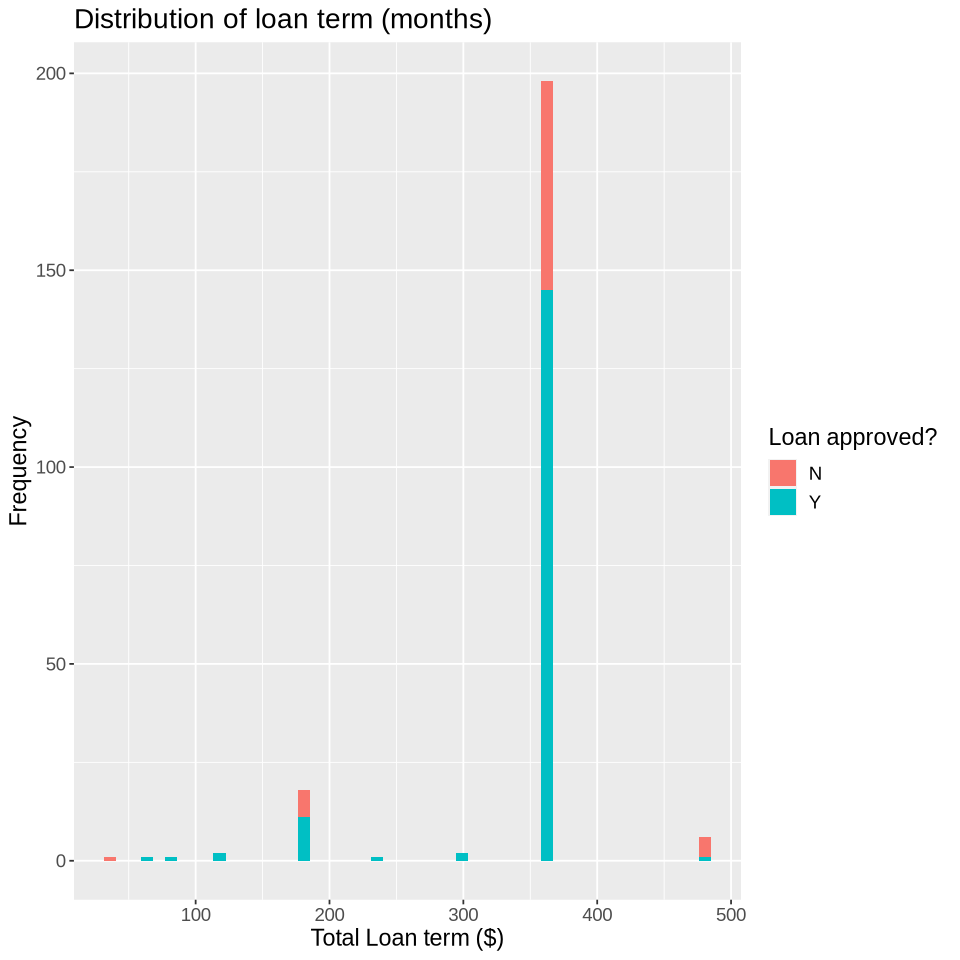

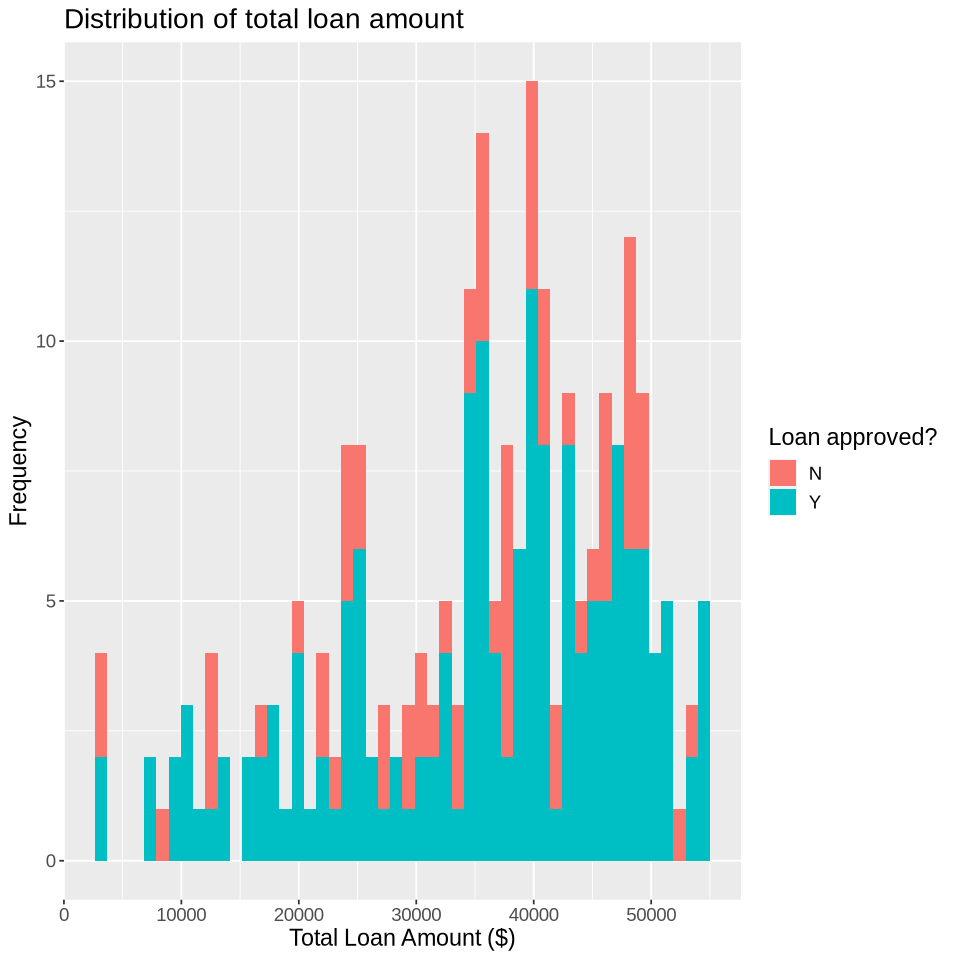

In [5]:
options(repr.plot.width=8, repr.plot.height=8)

income_dist_plot <- loan_train |>
    ggplot(aes(x=ApplicantIncome, fill=Loan_Status)) +
    geom_histogram(bins=50) +
    labs(title = "Distribution of applicant incomes", x = "Applicant Income ($)", y = "Frequency", fill="Loan approved?") +
    theme(text = element_text(size = 14))
income_dist_plot

coincome_dist_plot <- loan_train |>
    ggplot(aes(x=CoapplicantIncome, fill=Loan_Status)) +
    geom_histogram(bins=50) +
    labs(title = "Distribution of co-applicant incomes", x = "Co-applicant Income ($)", y = "Frequency", fill="Loan approved?") +
    theme(text = element_text(size = 14))
coincome_dist_plot

loan_amount_plot <- loan_train |>
    ggplot(aes(x=LoanAmount, fill=Loan_Status)) +
    geom_histogram(bins=50) +
    labs(title = "Distribution of loan amount (per month)", x = "Total Loan Amount ($)", y = "Frequency", fill="Loan approved?") +
    theme(text = element_text(size = 14))
loan_amount_plot

loan_term_plot <- loan_train |>
    ggplot(aes(x=Loan_Amount_Term, fill=Loan_Status)) +
    geom_histogram(bins=50) +
    labs(title = "Distribution of loan term (months)", x = "Total Loan term ($)", y = "Frequency", fill="Loan approved?") +
    theme(text = element_text(size = 14))
loan_term_plot

loan_combined_plot <- loan_train |>
    ggplot(aes(x=TotalLoanAmount, fill=Loan_Status)) +
    geom_histogram(bins=50) +
    labs(title = "Distribution of total loan amount", x = "Total Loan Amount ($)", y = "Frequency", fill="Loan approved?") +
    theme(text = element_text(size = 14))
loan_combined_plot

## Relationship between Income and Loan Amount

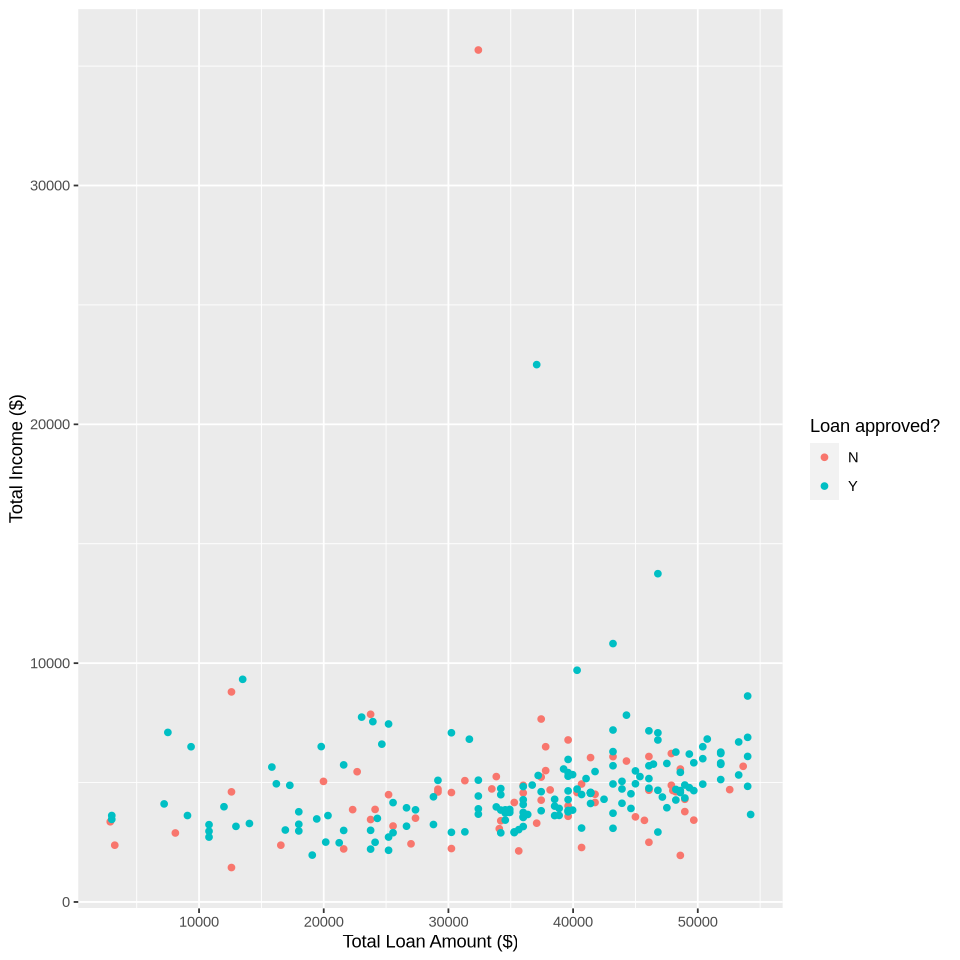

In [6]:
relationship_plot <- loan_train |>
    ggplot(aes(x=TotalLoanAmount, y=TotalIncome, color=Loan_Status)) +
    geom_point() + 
    labs(x="Total Loan Amount ($)", y="Total Income ($)", color="Loan approved?")
relationship_plot

In [13]:
loan_recipe <- recipe(Loan_Status ~ ApplicantIncome + CoapplicantIncome + TotalLoanAmount, data = loan_train) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 3) |>
  set_engine("kknn") |>
  set_mode("classification")

knn_fit <- workflow() |>
  add_recipe(loan_recipe) |>
  add_model(knn_spec) |>
  fit(data = loan_train)

loan_test_predictions <- predict(knn_fit, loan_test) |>
                 bind_cols(loan_test)

loan_test_predictions |>
 metrics(truth = Loan_Status, estimate = .pred_class)

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.58974359
kap,binary,-0.06757913


In [8]:
loan_data_filtered <- loan_data |> filter(Credit_History == 0 & Loan_Status == "Y")
loan_data_filtered

Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,TotalLoanAmount,TotalIncome
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<fct>,<dbl>,<dbl>
LP001431,Female,No,0,Graduate,No,2137,8980,137,360,0,Semiurban,Y,49320,11117
LP002068,Male,No,0,Graduate,No,4917,0,130,360,0,Rural,Y,46800,4917
LP002449,Male,Yes,0,Graduate,No,2483,2466,90,180,0,Rural,Y,16200,4949
